In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
data_df = pd.read_csv('data.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
#filling the missing values in data for shot_id_number
for i,e in enumerate(data_df['shot_id_number']):
    if math.isnan(e):
        data_df['shot_id_number'].loc[i] = data_df['shot_id_number'].loc[i-1] + 1.0

In [4]:
sample_column = sample_submission['shot_id_number'] - 1
X_test = data_df.iloc[sample_column]

In [5]:
data_df['Target_given'] = data_df['is_goal'].isnull()
train_test_group = data_df.groupby('Target_given', as_index = False)
test_df = train_test_group.get_group(True)
train_df = train_test_group.get_group(False)
del train_df['Target_given'], test_df['Target_given']

In [6]:
train_df = train_df.reset_index(drop = True)

In [8]:
X_train = train_df
y_train = X_train['is_goal']
del X_train['is_goal']
del X_train['Unnamed: 0'],  X_test['Unnamed: 0']

In [9]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
X_train.head()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,area_of_shot,...,lat/lng,type_of_shot,type_of_combined_shot,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,12.0,-157.0,0.0,10.0,1.0,0.0,2000-01,22.0,35.0,Left Side(L),...,"45.539131, -122.651648",shot - 45,NaN,20000012,1610612747,10.00,1.0,28.800,22.0000,35.0
1,35.0,-101.0,135.0,7.0,1.0,0.0,2000-01,45.0,36.0,Left Side Center(LC),...,"45.539131, -122.651648",shot - 25,NaN,20000012,1610612747,92.64,1.0,0.000,63.7216,54.4
2,43.0,138.0,175.0,6.0,1.0,0.0,2000-01,52.0,42.0,Right Side Center(RC),...,"45.539131, -122.651648",NaN,shot - 3,20000012,1610612747,NaN,1.0,122.608,52.0000,42.0
3,155.0,0.0,0.0,NaN,2.0,0.0,2000-01,19.0,20.0,Center(C),...,"45.539131, -122.651648",NaN,shot - 1,20000012,1610612747,42.64,2.0,0.000,19.0000,20.0
4,244.0,-145.0,-11.0,9.0,3.0,0.0,NaN,32.0,34.0,Left Side(L),...,"45.539131, -122.651648",shot - 17,NaN,20000012,1610612747,9.00,3.0,0.000,NaN,34.0


# Data Prep

In [10]:
X_train.isnull().sum()

match_event_id            1240
location_x                1156
location_y                1245
remaining_min             1244
power_of_shot             1200
knockout_match            1212
game_season               4632
remaining_sec             1250
distance_of_shot          1257
area_of_shot              1182
shot_basics               1283
range_of_shot             1248
team_name                 1212
date_of_game              1237
home/away                 1214
shot_id_number               0
lat/lng                   1247
type_of_shot             12136
type_of_combined_shot    12293
match_id                     0
team_id                      0
remaining_min.1           1209
power_of_shot.1           1208
knockout_match.1          1214
remaining_sec.1           1200
distance_of_shot.1        1244
dtype: int64

In [11]:
np.unique(data_df['team_id'])

array([1610612747], dtype=int64)

In [12]:
#As there is only one team for the whole data we can drop features: team_id and team_name
del X_train['team_id'] ,X_train['team_name'] ,X_test['team_id'] ,X_test['team_name'] 

Let's first check the quality of some features.
#### 1. Remaining min and Remaining sec

In [13]:
data_df[['remaining_min','remaining_min.1','remaining_sec','remaining_sec.1']].describe()

,remaining_min,remaining_min.1,remaining_sec,remaining_sec.1
count,29135.000000,29162.000000,29103.000000,29158.000000
mean,4.883233,18.204615,28.329382,39.027303
std,3.452533,29.416973,17.470663,29.835284
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,13.000000,17.000000
50%,5.000000,6.000000,28.000000,35.000000
75%,8.000000,11.000000,43.000000,52.000000
max,11.000000,128.761600,59.000000,144.785600


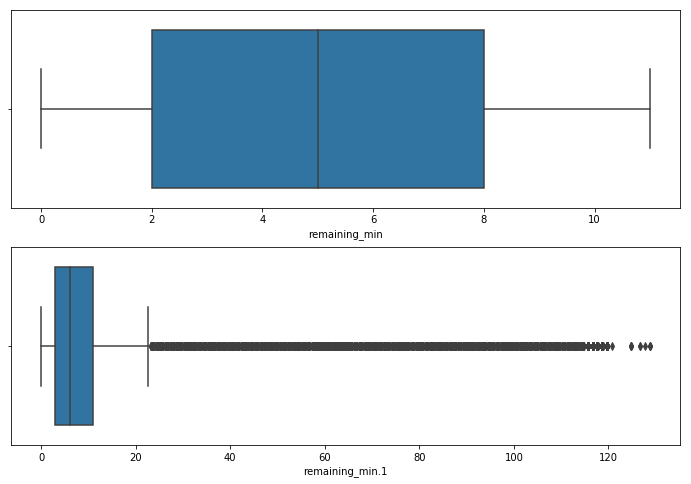

In [14]:
plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
sns.boxplot(x = data_df['remaining_min'])

plt.subplot(2,1,2)
sns.boxplot(x = data_df['remaining_min.1'])

plt.show()

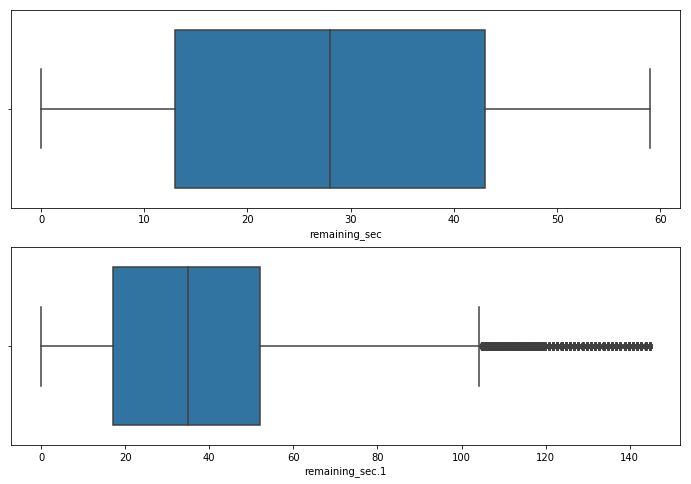

In [15]:
plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
sns.boxplot(x = data_df['remaining_sec'])

plt.subplot(2,1,2)
sns.boxplot(x = data_df['remaining_sec.1'])

plt.show()

As we can see the second column of min and sec, i.e. remaining_min.1 and remaining_min.2, has many outliers and the quality of that column is not good because:
        <ul>
            <li> Football is a 90min game, including extra time also remaining min won't reach 140mins. There may be some exceptions but not this many.</li>
             <li> As remaining_min column is given atmost 59 sec must be remaining, so that column also has many outliers
        </ul>
They are not totally useless. They can be used to fill some null values after we clean them.

#### so I am cleaning the remaining_min.1 and remaining_sec.1 column, remaining_min and remaining_sec do not need any cleaning. Then I will try to fill the null values in remaining_min and remaining_sec from the other two columns

#### Filling NULL values

For cleaning i will consider the remaining_min and remaining_sec as reference and clean, i.e.:
<ul>
    <li> I am taking the max(remaining_min) to be 11min and max(remaining_sec) as 59sec, all others lying outside this bound, I will consider them outliers. There is no problem in lower bound.
</ul>

In [16]:
for i, e in enumerate(X_train['remaining_min']):
    if math.isnan(e):
        if X_train['remaining_min.1'].iloc[i] <= 11:
            X_train['remaining_min'].iloc[i] = X_train['remaining_min.1'].iloc[i]
for i, e in enumerate(X_train['remaining_sec']):
    if math.isnan(e):
        if X_train['remaining_sec.1'].iloc[i] <= 59:
            X_train['remaining_sec'].iloc[i] = X_train['remaining_sec.1'].iloc[i]

In [17]:
for i, e in enumerate(X_test['remaining_min']):
    if math.isnan(e):
        if X_test['remaining_min.1'].iloc[i] <= 11:
            X_test['remaining_min'].iloc[i] = X_test['remaining_min.1'].iloc[i]
for i, e in enumerate(X_test['remaining_sec']):
    if math.isnan(e):
        if X_test['remaining_sec.1'].iloc[i] <= 59:
            X_test['remaining_sec'].iloc[i] = X_test['remaining_sec.1'].iloc[i]

In [18]:
display(X_test['remaining_min'].isnull().sum())
display(X_test['remaining_sec'].isnull().sum())

62

65

We were able to significantly reduce the number of null values. For now I keeping them as it is.
#### 2. Power of shot and distance of shot

In [19]:
data_df[['power_of_shot','power_of_shot.1','distance_of_shot','distance_of_shot.1']].describe()

,power_of_shot,power_of_shot.1,distance_of_shot,distance_of_shot.1
count,29211.000000,29158.000000,29130.000000,29129.000000
mean,2.519359,15.994109,33.448884,38.801852
std,1.153976,29.676815,9.369656,18.787711
min,1.000000,1.000000,20.000000,9.400000
25%,1.000000,2.000000,25.000000,26.000000
50%,3.000000,3.000000,35.000000,36.000000
75%,3.000000,4.000000,41.000000,44.000000
max,7.000000,118.360000,99.000000,115.728000


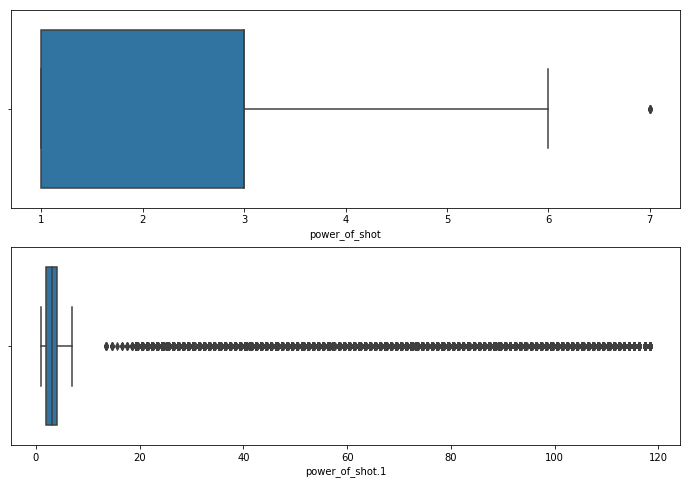

In [20]:
plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
sns.boxplot(x = data_df['power_of_shot'])

plt.subplot(2,1,2)
sns.boxplot(x = data_df['power_of_shot.1'])

plt.show()

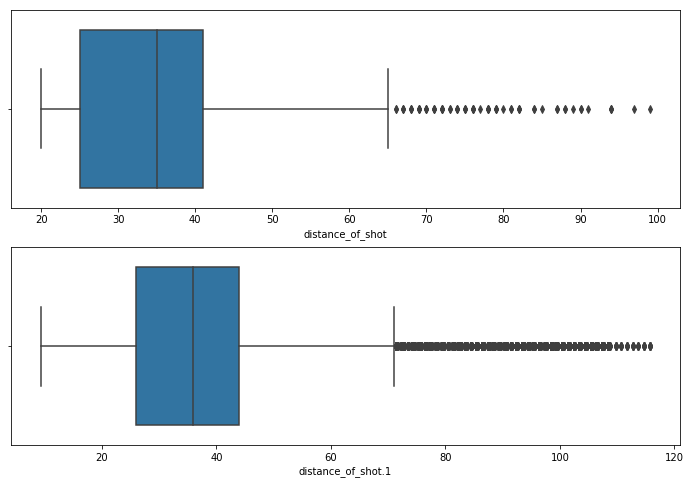

In [21]:
plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
sns.boxplot(x = data_df['distance_of_shot'])

plt.subplot(2,1,2)
sns.boxplot(x = data_df['distance_of_shot.1'])

plt.show()

In [22]:
for i, e in enumerate(X_train['power_of_shot']):
    if math.isnan(e):
        if X_train['power_of_shot.1'].iloc[i] <= 7 :
            X_train['power_of_shot'].iloc[i] = X_train['power_of_shot.1'].iloc[i]
for i, e in enumerate(X_train['distance_of_shot']):
    if math.isnan(e):
        if X_train['distance_of_shot.1'].iloc[i] <= 99 :
            X_train['distance_of_shot'].iloc[i] = X_train['distance_of_shot.1'].iloc[i]
for i, e in enumerate(X_test['power_of_shot']):
    if math.isnan(e):
        if X_test['power_of_shot.1'].iloc[i] <= 7 :
            X_test['power_of_shot'].iloc[i] = X_test['power_of_shot.1'].iloc[i]
for i, e in enumerate(X_test['distance_of_shot']):
    if math.isnan(e):
        if X_test['distance_of_shot.1'].iloc[i] <= 99 :
            X_test['distance_of_shot'].iloc[i] = X_test['distance_of_shot.1'].iloc[i]

#### 3. Knockout match
As we can see clearly Knockout match is a categorical variable. The value of this variable for the same match will be same. Therefore first we will use that information and then use knockout_match.1 variable

In [23]:
for i, e in enumerate(X_train['knockout_match']):
    if math.isnan(e):
        if X_train['match_id'].iloc[i] == X_train['match_id'].iloc[i-1]:
            X_train['knockout_match'].iloc[i] = X_train['knockout_match'].iloc[i-1]
        elif X_train['match_id'].iloc[i] == X_train['match_id'].iloc[i+1]:
            X_train['knockout_match'].iloc[i] = X_train['knockout_match'].iloc[i+1]
for i, e in enumerate(X_test['knockout_match']):
    if math.isnan(e):
        if X_test['match_id'].iloc[i] == X_test['match_id'].iloc[i-1]:
            X_test['knockout_match'].iloc[i] = X_test['knockout_match'].iloc[i-1]
        elif X_test['match_id'].iloc[i] == X_test['match_id'].iloc[i+1]:
            X_test['knockout_match'].iloc[i] = X_test['knockout_match'].iloc[i+1]
for i, e in enumerate(X_train['knockout_match']):
    if math.isnan(e):
        if X_train['knockout_match.1'].iloc[i] == 0:
            X_train['knockout_match'].iloc[i] = X_train['knockout_match.1'].iloc[i]
        if X_train['knockout_match.1'].iloc[i] == 1:
            X_train['knockout_match'].iloc[i] = X_train['knockout_match.1'].iloc[i]
for i, e in enumerate(X_test['knockout_match']):
    if math.isnan(e):
        if X_test['knockout_match.1'].iloc[i] == 0:
            X_test['knockout_match'].iloc[i] = X_test['knockout_match.1'].iloc[i]
        if X_test['knockout_match.1'].iloc[i] == 1:
            X_test['knockout_match'].iloc[i] = X_test['knockout_match.1'].iloc[i]

In [24]:
X_test.drop(['is_goal'], axis = 1, inplace = True)
X_train.drop(['knockout_match.1','power_of_shot.1', 'distance_of_shot.1','remaining_min.1','remaining_sec.1'], axis = 1, inplace = True)
X_test.drop(['knockout_match.1','power_of_shot.1', 'distance_of_shot.1','remaining_min.1','remaining_sec.1'], axis = 1, inplace = True)

So, we used the mutiple columns to fill some values now we dont need them anymore so I deleted them. Now let's try to fill up some columns that are obvious, like 'lat/lng' 'game_season'.
This will be filled easily as lat/lng is same for a match and game_season can be filled by using the preceding and succeding value of the same column.

#### 4. game season

In [25]:
for i, e in enumerate(X_train['game_season']):
    if pd.isnull(e):
        if X_train['game_season'].iloc[i-1] == X_train['game_season'].iloc[i+1]:
            X_train['game_season'].iloc[i] = X_train['game_season'].iloc[i-1]
for i, e in enumerate(X_test['game_season']):
    if pd.isnull(e):
        if X_test['game_season'].iloc[i-1] == X_test['game_season'].iloc[i+1]:
            X_test['game_season'].iloc[i] = X_test['game_season'].iloc[i-1]

#### 5. Lat/Lng

In [26]:
for i, e in enumerate(X_train['lat/lng']):
    if pd.isnull(e):
        if X_train['match_id'].iloc[i] == X_train['match_id'].iloc[i+1]:
            X_train['lat/lng'].iloc[i] = X_train['lat/lng'].iloc[i+1]
        if X_train['match_id'].iloc[i] == X_train['match_id'].iloc[i-1]:
            X_train['lat/lng'].iloc[i] = X_train['lat/lng'].iloc[i-1]
for i, e in enumerate(X_test['lat/lng']):
    if pd.isnull(e):
        if X_test['match_id'].iloc[i] == X_test['match_id'].iloc[i+1]:
            X_test['lat/lng'].iloc[i] = X_test['lat/lng'].iloc[i+1]
        if X_test['match_id'].iloc[i] == X_test['match_id'].iloc[i-1]:
            X_test['lat/lng'].iloc[i] = X_test['lat/lng'].iloc[i-1]

I observed that for columns 'type_of_shot' and 'type_of_combined_shot' where one value is given other is not given and the sum of there non.null values sum up to total number of rows. So I think that it is one column split into two. So, I will go ahead and merge them.
#### 6. type_of_shot

In [27]:
X_train['type_of_shot'] = X_train['type_of_shot'].fillna(X_train['type_of_combined_shot'])
X_test['type_of_shot'] = X_test['type_of_shot'].fillna(X_test['type_of_combined_shot'])
X_train.drop('type_of_combined_shot', axis = 1, inplace = True)
X_test.drop('type_of_combined_shot', axis = 1, inplace = True)

I think that for filling rest of the columns we will need some insights into the data, to find relationship with other columns. So, let's perform EDA
# EDA

In [28]:
X_train.describe(include = 'O')

,game_season,area_of_shot,shot_basics,range_of_shot,date_of_game,home/away,lat/lng,type_of_shot
count,22830,23247,23146,23181,23192,23215,24423,24429
unique,20,6,7,5,1557,74,38,57
top,2005-06,Center(C),Mid Range,Less Than 8 ft.,2016-04-13,MANU @ SAS,"42.982923, -71.446094",shot - 3
freq,1719,10177,9488,7064,39,767,11875,9474


In [30]:
X_train['is_goal'] = y_train

In [31]:
X_train.describe()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,remaining_sec,distance_of_shot,shot_id_number,match_id,is_goal
count,23189.000000,23273.000000,23184.000000,24122.000000,24141.000000,24428.000000,24172.000000,24331.000000,24429.000000,2.442900e+04,24429.000000
mean,249.575402,7.494178,91.461180,4.880192,2.520070,0.146635,28.347390,33.665937,15329.854804,2.474317e+07,0.445331
std,150.052347,110.126457,88.041628,3.453805,1.152094,0.353749,17.517907,9.829759,8860.893604,7.745041e+06,0.497013
min,2.000000,-250.000000,-44.000000,0.000000,1.000000,0.000000,0.000000,9.400000,2.000000,2.000001e+07,0.000000
25%,111.000000,-67.000000,4.000000,2.000000,1.000000,0.000000,13.000000,25.000000,7654.000000,2.050006e+07,0.000000
50%,254.000000,0.000000,74.000000,5.000000,3.000000,0.000000,28.000000,35.000000,15340.000000,2.090034e+07,0.000000
75%,369.000000,95.000000,160.000000,8.000000,3.000000,0.000000,43.000000,41.000000,22969.000000,2.960027e+07,1.000000
max,653.000000,248.000000,791.000000,11.000000,7.000000,1.000000,59.000000,99.000000,30697.000000,4.990009e+07,1.000000


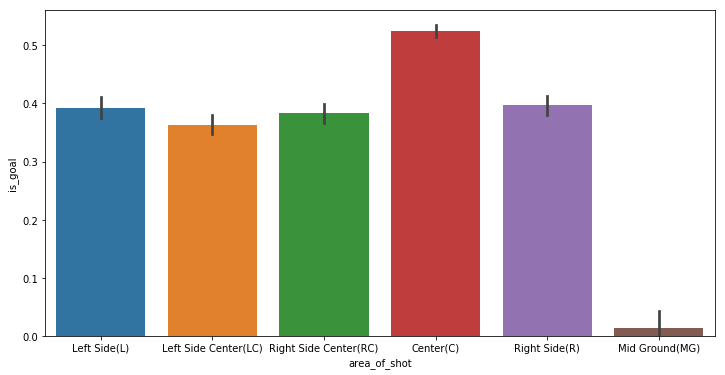

In [33]:
plt.figure(figsize = (12,6))
sns.barplot(x = X_train['area_of_shot'], y = X_train['is_goal'])

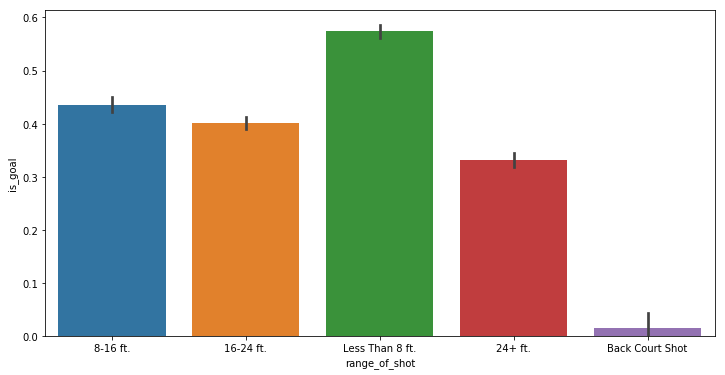

In [34]:
plt.figure(figsize = (12,6))
sns.barplot(x = X_train['range_of_shot'], y = X_train['is_goal'])

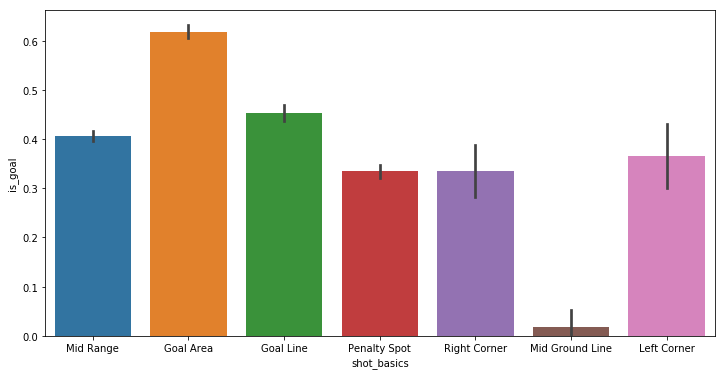

In [36]:
plt.figure(figsize = (12,6))
sns.barplot(x = X_train['shot_basics'], y = X_train['is_goal'])

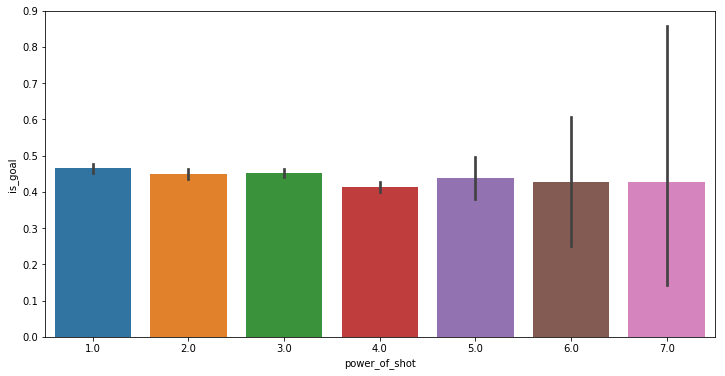

In [37]:
plt.figure(figsize = (12,6))
sns.barplot(x = X_train['power_of_shot'], y = X_train['is_goal'])

#### Observation:
<ul>
    <li>lat/lng-(42/-71) appears the highest number of time so I think it should be the lat/lng of the home ground of manchester united.</li>
    <li>According to our assumption we can create a new home away feature.</li>
    <li>As expected the goal scoring is highly dependent on area_of_shot, range_of_shot, shot_basics but the problem is they have high number of null values.</li>
</ul>

To be able to fill the null values in these columns we need their dependence on some other variable.


In [40]:
data_df.pivot_table(index = ['range_of_shot','area_of_shot','shot_basics'], values = ['is_goal'])

is_goal
range_of_shot   area_of_shot          shot_basics              
16-24 ft.       Center(C)             Mid Range        0.404126
                Left Side Center(LC)  Mid Range        0.415409
                Left Side(L)          Mid Range        0.377515
                Right Side Center(RC) Mid Range        0.425532
                Right Side(R)         Mid Range        0.371981
24+ ft.         Center(C)             Penalty Spot     0.337302
                Left Side Center(LC)  Penalty Spot     0.317373
                Left Side(L)          Left Corner      0.346939
                Right Side Center(RC) Penalty Spot     0.350943
                Right Side(R)         Right Corner     0.336957
8-16 ft.        Center(C)             Goal Line        0.489531
                                      Mid Range        0.497817
                Left Side(L)          Goal Line        0.410156
                                      Mid Range        0.410700
                Right Side(R)         Goal Line        0.456140
                                      Mid Range        0.407432
Back Court Shot Mid Ground(MG)        Mid Ground Line  0.018519
                                      Penalty Spot     0.000000
Less Than 8 ft. Center(C)             Goal Area        0.617647
                                      Goal Line        0.436906

In [41]:
#Filling categorical variable 
for i, e in enumerate(X_train['area_of_shot']):
    if pd.isnull(e):
        if X_train['shot_basics'].iloc[i] == 'Goal Area' or X_train['shot_basics'].iloc[i] == 'Goal Line':
            X_train['area_of_shot'].iloc[i] = 'Center(C)'
        if X_train['shot_basics'].iloc[i] == 'Right Corner':
            X_train['area_of_shot'].iloc[i] = 'Right Side(R)'
        if X_train['shot_basics'].iloc[i] == 'Left Corner':
            X_train['area_of_shot'].iloc[i] = 'Left Side(L)'
        if X_train['shot_basics'].iloc[i] == 'Mid Ground Line':
            X_train['area_of_shot'].iloc[i] = 'Mid Ground(MG)'
for i, e in enumerate(X_test['area_of_shot']):
    if pd.isnull(e):
        if X_test['shot_basics'].iloc[i] == 'Goal Area' or X_test['shot_basics'].iloc[i] == 'Goal Line':
            X_test['area_of_shot'].iloc[i] = 'Center(C)'
        if X_test['shot_basics'].iloc[i] == 'Right Corner':
            X_test['area_of_shot'].iloc[i] = 'Right Side(R)'
        if X_test['shot_basics'].iloc[i] == 'Left Corner':
            X_test['area_of_shot'].iloc[i] = 'Left Side(L)'
        if X_test['shot_basics'].iloc[i] == 'Mid Ground Line':
            X_test['area_of_shot'].iloc[i] = 'Mid Ground(MG)'
for i,e in enumerate(X_train['range_of_shot']):
    if pd.isnull(e):
        if X_train['shot_basics'].iloc[i] == 'Goal Area':
            X_train['range_of_shot'].iloc[i] = 'Less Than 8 ft.'
        if X_train['shot_basics'].iloc[i] == 'Left Corner' or X_train['shot_basics'].iloc[i] == 'Right Corner':
            X_train['range_of_shot'].iloc[i] = '24+ ft.'
        if X_train['shot_basics'].iloc[i] == 'Mid Ground Line':
            X_train['range_of_shot'].iloc[i] = 'Back Court Shot'
for i,e in enumerate(X_test['range_of_shot']):
    if pd.isnull(e):
        if X_test['shot_basics'].iloc[i] == 'Goal Area':
            X_test['range_of_shot'].iloc[i] = 'Less Than 8 ft.'
        if X_test['shot_basics'].iloc[i] == 'Left Corner' or X_test['shot_basics'].iloc[i] == 'Right Corner':
            X_test['range_of_shot'].iloc[i] = '24+ ft.'
        if X_test['shot_basics'].iloc[i] == 'Mid Ground Line':
            X_test['range_of_shot'].iloc[i] = 'Back Court Shot'
for i,e in enumerate(X_test['range_of_shot']):
    if pd.isnull(e):
        if X_test['area_of_shot'].iloc[i] == 'Mid Ground(MG)':
            X_test['range_of_shot'].iloc[i] = 'Back Court Shot'
for i,e in enumerate(X_train['range_of_shot']):
    if pd.isnull(e):
        if X_train['area_of_shot'].iloc[i] == 'Mid Ground(MG)':
            X_train['range_of_shot'].iloc[i] = 'Back Court Shot'
for i,e in enumerate(X_test['shot_basics']):
    if pd.isnull(e):
        if X_test['range_of_shot'].iloc[i] == '16-24 ft.':
            X_test['shot_basics'].iloc[i] = 'Mid Range'
for i,e in enumerate(X_train['range_of_shot']):
    if pd.isnull(e):
        if X_train['range_of_shot'].iloc[i] == '16-24 ft.':
            X_train['shot_basics'].iloc[i] = 'Mid Range'
for i,e in enumerate(X_train['shot_basics']):
    if pd.isnull(e):
        if X_train['range_of_shot'].iloc[i] == '24+ ft.':
            if X_train['area_of_shot'].iloc[i] == 'Center(C)' or X_train['area_of_shot'].iloc[i] == 'Left Side Center(LC)' or X_train['area_of_shot'].iloc[i] == 'Right Side Center(RC)':
                X_train['shot_basics'].iloc[i] = 'Penalty Spot'
            if X_train['area_of_shot'].iloc[i] == 'Left Side(L)':
                X_train['shot_basics'].iloc[i] = 'Left Corner'
            if X_train['area_of_shot'].iloc[i] == 'Right Side(R)':
                X_train['shot_basics'].iloc[i] = 'Right Corner'
for i,e in enumerate(X_test['shot_basics']):
    if pd.isnull(e):
        if X_test['range_of_shot'].iloc[i] == '24+ ft.':
            if X_test['area_of_shot'].iloc[i] == 'Center(C)' or X_test['area_of_shot'].iloc[i] == 'Left Side Center(LC)' or X_test['area_of_shot'].iloc[i] == 'Right Side Center(RC)':
                X_test['shot_basics'].iloc[i] = 'Penalty Spot'
            if X_test['area_of_shot'].iloc[i] == 'Left Side(L)':
                X_test['shot_basics'].iloc[i] = 'Left Corner'
            if X_test['area_of_shot'].iloc[i] == 'Right Side(R)':
                X_test['shot_basics'].iloc[i] = 'Right Corner'

#### 1. range_of_shot

In [46]:
X_train[['range_of_shot','location_x','location_y','distance_of_shot']].groupby('range_of_shot').mean()

,location_x,location_y,distance_of_shot
range_of_shot,,,
16-24 ft.,13.967514,122.222920,38.677051
24+ ft.,7.647278,189.505177,45.259797
8-16 ft.,8.338493,63.913872,32.216543
Back Court Shot,5.483871,548.359375,75.361111
Less Than 8 ft.,0.813255,12.637710,22.003590


#### Observation:
<ul>
    <li>We see that range_of_shot is strongly related to location_y and distance_of_shot</li>
</ul>
So, I will go ahead and try to fill range_of_shot. 

#### Linear model is a obvious choice for this classification

In [49]:
X_1 = data_df[['range_of_shot','location_y','distance_of_shot']].copy()
X_1 = X_1.dropna()
X_train1 = X_1[['location_y','distance_of_shot']]
y_train1 = X_1['range_of_shot']

In [50]:
clf_1 = LogisticRegression()
clf_1.fit(X_train1,y_train1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [58]:
for i, e in enumerate(X_train['range_of_shot']):
    if pd.isnull(e):
        if not(pd.isnull(X_train['location_y'].iloc[i]) or pd.isnull(X_train['distance_of_shot'].iloc[i])):
            ar = X_train[['location_y','distance_of_shot']].iloc[i]
            X_train['range_of_shot'].iloc[i] = clf_1.predict(ar.values.reshape(1,2))[0]

In [60]:
for i, e in enumerate(X_test['range_of_shot']):
    if pd.isnull(e):
        if not(pd.isnull(X_test['location_y'].iloc[i]) or pd.isnull(X_test['distance_of_shot'].iloc[i])):
            ar = X_test[['location_y','distance_of_shot']].iloc[i]
            X_test['range_of_shot'].iloc[i] = clf_1.predict(ar.values.reshape(1,2))[0]

#### 2. Area_of_shot

In [64]:
X_train[['location_x','location_y','distance_of_shot','area_of_shot']].groupby('area_of_shot').mean()

,location_x,location_y,distance_of_shot
area_of_shot,,,
Center(C),1.242295,61.647857,26.711367
Left Side Center(LC),-139.550554,176.664467,42.448262
Left Side(L),-140.235467,45.906701,35.155622
Mid Ground(MG),5.483871,548.359375,75.361111
Right Side Center(RC),133.936311,176.413733,42.243125
Right Side(R),141.812481,41.137019,35.119778


In [65]:
X_train.pivot_table(index = ['range_of_shot','area_of_shot'], values= 'is_goal')

is_goal
range_of_shot   area_of_shot                   
16-24 ft.       Center(C)              0.398332
                Left Side Center(LC)   0.413247
                Left Side(L)           0.367539
                Right Side Center(RC)  0.420504
                Right Side(R)          0.378903
24+ ft.         Center(C)              0.329341
                Left Side Center(LC)   0.320245
                Left Side(L)           0.367257
                Right Side Center(RC)  0.343610
                Right Side(R)          0.340625
8-16 ft.        Center(C)              0.488636
                Left Side(L)           0.410241
                Right Side(R)          0.415369
Back Court Shot Center(C)              0.000000
                Mid Ground(MG)         0.013889
Less Than 8 ft. Center(C)              0.573394
                Left Side(L)           0.400000
                Right Side(R)          0.600000

#### Observation:
<ul>
    <li>We see that area_of_shot is strongly related to location_x, location_y, distance_of_shot and range_of_shot</li>
</ul> 

#### Linear model is will not be a very good choice because of overlapping values of location_x and location_y for different values of area_of_shot. So, I will use random forest classifier for this.

In [67]:
X_2 = data_df[['range_of_shot','location_y','distance_of_shot','location_x','area_of_shot']].copy()
X_2 = X_2.dropna()
X_train2 = X_2[['location_y','distance_of_shot','location_x','range_of_shot']]
y_train2 = X_2['area_of_shot']

In [69]:
for f in X_train2.columns:
    if X_train2[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train2[f].values))
        X_train2[f] = lbl.transform(list(X_train2[f].values))

In [71]:
clf_2.fit(X_train2,y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [72]:
X_temp_train = X_train[['location_y','distance_of_shot','location_x','range_of_shot']].copy()
for f in X_temp_train.columns:
    if X_temp_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_temp_train[f].values))
        X_temp_train[f] = lbl.transform(list(X_temp_train[f].values))

In [73]:
X_temp_test = X_test[['location_y','distance_of_shot','location_x','range_of_shot']].copy()
for f in X_temp_test.columns:
    if X_temp_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_temp_test[f].values))
        X_temp_test[f] = lbl.transform(list(X_temp_test[f].values))

In [74]:
for i, e in enumerate(X_train['area_of_shot']):
    if pd.isnull(e):
        if not(pd.isnull(X_temp_train['location_y'].iloc[i]) or pd.isnull(X_temp_train['distance_of_shot'].iloc[i]) or pd.isnull(X_temp_train['location_x'].iloc[i]) or pd.isnull(X_temp_train['range_of_shot'].iloc[i])):
            ar = X_temp_train[['location_y','distance_of_shot','location_x','range_of_shot']].iloc[i]
            X_train['area_of_shot'].iloc[i] = clf_2.predict(ar.values.reshape(1,4))[0]

for i, e in enumerate(X_test['area_of_shot']):
    if pd.isnull(e):
        if not(pd.isnull(X_temp_test['location_y'].iloc[i]) or pd.isnull(X_temp_test['distance_of_shot'].iloc[i]) or pd.isnull(X_temp_test['location_x'].iloc[i]) or pd.isnull(X_temp_test['range_of_shot'].iloc[i])):
            ar = X_temp_test[['location_y','distance_of_shot','location_x','range_of_shot']].iloc[i]
            X_test['area_of_shot'].iloc[i] = clf_2.predict(ar.values.reshape(1,4))[0]

In [78]:
del X_temp_train, X_temp_test

#### 3. shot_basics

In [79]:
X_train[['location_x','location_y','distance_of_shot','area_of_shot','shot_basics']].groupby('shot_basics').mean()

,location_x,location_y,distance_of_shot
shot_basics,,,
Goal Area,0.325816,3.058356,20.745997
Goal Line,4.776946,70.180788,28.502105
Left Corner,-232.530806,19.952607,43.141964
Mid Ground Line,-4.959184,573.745098,77.947368
Mid Range,12.812714,96.252193,36.702603
Penalty Spot,3.498942,211.443579,45.599771
Right Corner,231.546667,18.829431,42.822930


In [80]:
X_train.pivot_table(index = ['range_of_shot','area_of_shot','shot_basics'], values= 'is_goal')

is_goal
range_of_shot   area_of_shot          shot_basics              
16-24 ft.       Center(C)             Goal Line        0.242424
                                      Mid Range        0.402655
                Left Side Center(LC)  Mid Range        0.411808
                Left Side(L)          Goal Line        0.000000
                                      Mid Range        0.375789
                Right Side Center(RC) Mid Range        0.423673
                Right Side(R)         Goal Line        0.500000
                                      Mid Range        0.374679
24+ ft.         Center(C)             Goal Line        0.333333
                                      Mid Range        0.333333
                                      Penalty Spot     0.323360
                Left Side Center(LC)  Mid Range        0.333333
                                      Penalty Spot     0.319788
                Left Side(L)          Left Corner      0.364444
                                      Mid Range        1.000000
                Right Side Center(RC) Mid Range        0.250000
                                      Penalty Spot     0.343835
                Right Side(R)         Mid Range        0.333333
                                      Right Corner     0.340694
8-16 ft.        Center(C)             Goal Line        0.487478
                                      Mid Range        0.495763
                Left Side(L)          Goal Line        0.407692
                                      Mid Range        0.411374
                Right Side(R)         Goal Line        0.457143
                                      Mid Range        0.405270
Back Court Shot Center(C)             Penalty Spot     0.000000
                Mid Ground(MG)        Mid Ground Line  0.017544
                                      Penalty Spot     0.000000
Less Than 8 ft. Center(C)             Goal Area        0.618073
                                      Goal Line        0.439815
                                      Mid Range        1.000000
                Left Side(L)          Goal Line        0.666667
                                      Mid Range        0.000000
                Right Side(R)         Goal Line        0.800000
                                      Mid Range        0.333333

#### I will be using randomforestclassifier for this also.

In [81]:
X_3 = data_df[['range_of_shot','location_y','distance_of_shot','location_x','area_of_shot','shot_basics']].copy()
X_3 = X_3.dropna()
X_train3 = X_3[['location_y','distance_of_shot','location_x','range_of_shot','area_of_shot']]
y_train3 = X_3['shot_basics']

In [83]:
for f in X_train3.columns:
    if X_train3[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train3[f].values))
        X_train3[f] = lbl.transform(list(X_train3[f].values))

In [85]:
clf_3 = RandomForestClassifier(n_estimators=1000,random_state=0)
clf_3.fit(X_train3,y_train3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [86]:
X_temp_train = X_train[['location_y','distance_of_shot','location_x','range_of_shot','area_of_shot']].copy()
for f in X_temp_train.columns:
    if X_temp_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_temp_train[f].values))
        X_temp_train[f] = lbl.transform(list(X_temp_train[f].values))

X_temp_test = X_test[['location_y','distance_of_shot','location_x','range_of_shot','area_of_shot']].copy()
for f in X_temp_test.columns:
    if X_temp_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_temp_test[f].values))
        X_temp_test[f] = lbl.transform(list(X_temp_test[f].values))

In [88]:
for i, e in enumerate(X_train['shot_basics']):
    if pd.isnull(e):
        if not(pd.isnull(X_temp_train['location_y'].iloc[i]) or pd.isnull(X_temp_train['distance_of_shot'].iloc[i]) or pd.isnull(X_temp_train['location_x'].iloc[i]) or pd.isnull(X_temp_train['range_of_shot'].iloc[i]) or pd.isnull(X_temp_train['area_of_shot'].iloc[i])):
            ar = X_temp_train[['location_y','distance_of_shot','location_x','range_of_shot','area_of_shot']].iloc[i]
            X_train['shot_basics'].iloc[i] = clf_3.predict(ar.values.reshape(1,5))[0]

for i, e in enumerate(X_test['shot_basics']):
    if pd.isnull(e):
        if not(pd.isnull(X_temp_test['location_y'].iloc[i]) or pd.isnull(X_temp_test['distance_of_shot'].iloc[i]) or pd.isnull(X_temp_test['location_x'].iloc[i]) or pd.isnull(X_temp_test['range_of_shot'].iloc[i]) or pd.isnull(X_temp_test['area_of_shot'].iloc[i])):
            ar = X_temp_test[['location_y','distance_of_shot','location_x','range_of_shot','area_of_shot']].iloc[i]
            X_test['shot_basics'].iloc[i] = clf_3.predict(ar.values.reshape(1,5))[0]

In [98]:
del X_temp_train, X_temp_test

In [110]:
X_1 = data_df[['range_of_shot','location_y','distance_of_shot']].copy()
X_1 = X_1.dropna()
X_train1 = X_1[['location_y','distance_of_shot']]
y_train1 = X_1['range_of_shot']

#### 1. Range of shot

In [111]:
clf_4 = xgb.XGBClassifier(n_estimators=500,
                        n_jobs=4,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=np.nan)
clf_4.fit(X_train1,y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=4,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [117]:
X_train['range_of_shot.1'] = clf_4.predict(X_train[['location_y','distance_of_shot']])

In [120]:
X_train['range_of_shot'] = X_train['range_of_shot'].fillna(X_train['range_of_shot.1'])
X_train.drop(['range_of_shot.1'], axis = 1, inplace = True)

In [121]:
X_test['range_of_shot.1'] = clf_4.predict(X_test[['location_y','distance_of_shot']])

In [122]:
X_test['range_of_shot'] = X_test['range_of_shot'].fillna(X_test['range_of_shot.1'])
X_test.drop(['range_of_shot.1'], axis = 1, inplace = True)

#### 2. area_of_shot

In [124]:
X_2 = data_df[['range_of_shot','location_y','distance_of_shot','location_x','area_of_shot']].copy()
X_2 = X_2.dropna()
X_train2 = X_2[['location_y','distance_of_shot','location_x','range_of_shot']]
y_train2 = X_2['area_of_shot']

In [125]:
for f in X_train2.columns:
    if X_train2[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train2[f].values))
        X_train2[f] = lbl.transform(list(X_train2[f].values))

In [126]:
clf_4.fit(X_train2,y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=4,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [127]:
x_train = X_train[['location_y','distance_of_shot','location_x','range_of_shot']].copy()
x_test = X_test[['location_y','distance_of_shot','location_x','range_of_shot']].copy()
for f in x_train.columns:
    if x_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[f].values))
        x_train[f] = lbl.transform(list(x_train[f].values))
for f in x_test.columns:
    if x_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[f].values))
        x_test[f] = lbl.transform(list(x_test[f].values))

In [128]:
X_train['area_of_shot.1'] = clf_4.predict(x_train)
X_test['area_of_shot.1'] = clf_4.predict(x_test)

In [130]:
X_train['area_of_shot'] = X_train['area_of_shot'].fillna(X_train['area_of_shot.1'])
X_test['area_of_shot'] = X_test['area_of_shot'].fillna(X_test['area_of_shot.1'])
X_train.drop(['area_of_shot.1'], axis = 1, inplace = True)
X_test.drop(['area_of_shot.1'], axis = 1, inplace = True)

In [132]:
del x_train, x_test

#### 3. shot_basics

In [136]:
X_3 = data_df[['range_of_shot','location_y','distance_of_shot','location_x','area_of_shot','shot_basics']].copy()
X_3 = X_3.dropna()
X_train3 = X_3[['location_y','distance_of_shot','location_x','range_of_shot','area_of_shot']]
y_train3 = X_3['shot_basics']

In [137]:
for f in X_train3.columns:
    if X_train3[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train3[f].values))
        X_train3[f] = lbl.transform(list(X_train3[f].values))

In [138]:
clf_4.fit(X_train3,y_train3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=4,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [139]:
x_train = X_train[['location_y','distance_of_shot','location_x','range_of_shot','area_of_shot']].copy()
x_test = X_test[['location_y','distance_of_shot','location_x','range_of_shot','area_of_shot']].copy()
for f in x_train.columns:
    if x_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[f].values))
        x_train[f] = lbl.transform(list(x_train[f].values))
for f in x_test.columns:
    if x_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[f].values))
        x_test[f] = lbl.transform(list(x_test[f].values))

In [140]:
X_train['shot_basics.1'] = clf_4.predict(x_train)
X_test['shot_basics.1'] = clf_4.predict(x_test)

In [142]:
X_train['shot_basics'] = X_train['shot_basics'].fillna(X_train['shot_basics.1'])
X_test['shot_basics'] = X_test['shot_basics'].fillna(X_test['shot_basics.1'])
X_train.drop(['shot_basics.1'], axis = 1, inplace = True)
X_test.drop(['shot_basics.1'], axis = 1, inplace = True)

#### 4. distance_of_shot

In [149]:
clf_5 = xgb.XGBRegressor(missing = np.nan)

In [151]:
X_3 = data_df[['range_of_shot','location_y','distance_of_shot','location_x','area_of_shot','shot_basics']].copy()
X_3 = X_3.dropna()
X_train3 = X_3[['location_y','location_x','range_of_shot','area_of_shot','shot_basics']]
y_train3 = X_3['distance_of_shot']

In [152]:
for f in X_train3.columns:
    if X_train3[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train3[f].values))
        X_train3[f] = lbl.transform(list(X_train3[f].values))

In [153]:
clf_5.fit(X_train3,y_train3)

[00:52:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [154]:
x_train = X_train[['location_y','location_x','range_of_shot','area_of_shot','shot_basics']].copy()
x_test = X_test[['location_y','location_x','range_of_shot','area_of_shot','shot_basics']].copy()
for f in x_train.columns:
    if x_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[f].values))
        x_train[f] = lbl.transform(list(x_train[f].values))
for f in x_test.columns:
    if x_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[f].values))
        x_test[f] = lbl.transform(list(x_test[f].values))

In [156]:
X_train['distance_of_shot.1'] = clf_5.predict(x_train)
X_test['distance_of_shot.1'] = clf_5.predict(x_test)

In [158]:
X_train['distance_of_shot'] = X_train['distance_of_shot'].fillna(X_train['distance_of_shot.1'])
X_test['distance_of_shot'] = X_test['distance_of_shot'].fillna(X_test['distance_of_shot.1'])
X_train.drop(['distance_of_shot.1'], axis = 1, inplace = True)
X_test.drop(['distance_of_shot.1'], axis = 1, inplace = True)

#### 5. location_x

In [159]:
X_3 = data_df[['range_of_shot','location_y','distance_of_shot','location_x','area_of_shot','shot_basics']].copy()
X_3 = X_3.dropna()
X_train3 = X_3[['location_y','range_of_shot','area_of_shot','shot_basics','distance_of_shot']]
y_train3 = X_3['location_x']

In [160]:
for f in X_train3.columns:
    if X_train3[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train3[f].values))
        X_train3[f] = lbl.transform(list(X_train3[f].values))

In [161]:
clf_5.fit(X_train3,y_train3)

[00:57:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [162]:
x_train = X_train[['location_y','range_of_shot','area_of_shot','shot_basics','distance_of_shot']].copy()
x_test = X_test[['location_y','range_of_shot','area_of_shot','shot_basics','distance_of_shot']].copy()
for f in x_train.columns:
    if x_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[f].values))
        x_train[f] = lbl.transform(list(x_train[f].values))
for f in x_test.columns:
    if x_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[f].values))
        x_test[f] = lbl.transform(list(x_test[f].values))

In [163]:
X_train['location_x.1'] = clf_5.predict(x_train)
X_test['location_x.1'] = clf_5.predict(x_test)

In [167]:
X_train['location_x'] = X_train['location_x'].fillna(X_train['location_x.1'])
X_test['location_x'] = X_test['location_x'].fillna(X_test['location_x.1'])
X_train.drop(['location_x.1'], axis = 1, inplace = True)
X_test.drop(['location_x.1'], axis = 1, inplace = True)

#### 6. location_y

In [169]:
X_3 = data_df[['range_of_shot','location_y','distance_of_shot','location_x','area_of_shot','shot_basics']].copy()
X_3 = X_3.dropna()
X_train3 = X_3[['location_x','range_of_shot','area_of_shot','shot_basics','distance_of_shot']]
y_train3 = X_3['location_y']

In [170]:
for f in X_train3.columns:
    if X_train3[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train3[f].values))
        X_train3[f] = lbl.transform(list(X_train3[f].values))

In [171]:
clf_5.fit(X_train3,y_train3)

[01:08:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [172]:
x_train = X_train[['location_x','range_of_shot','area_of_shot','shot_basics','distance_of_shot']].copy()
x_test = X_test[['location_x','range_of_shot','area_of_shot','shot_basics','distance_of_shot']].copy()
for f in x_train.columns:
    if x_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[f].values))
        x_train[f] = lbl.transform(list(x_train[f].values))
for f in x_test.columns:
    if x_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[f].values))
        x_test[f] = lbl.transform(list(x_test[f].values))

In [173]:
X_train['location_y.1'] = clf_5.predict(x_train)
X_test['location_y.1'] = clf_5.predict(x_test)

In [175]:
X_train['location_y'] = X_train['location_y'].fillna(X_train['location_y.1'])
X_test['location_y'] = X_test['location_y'].fillna(X_test['location_y.1'])
X_train.drop(['location_y.1'], axis = 1, inplace = True)
X_test.drop(['location_y.1'], axis = 1, inplace = True)

#### 7. remaining_min and remaining_sec

In [177]:
X_train['remaining_min.1'] = X_train['remaining_min'].mean()

In [178]:
X_test['remaining_min.1'] = X_test['remaining_min'].mean()

In [179]:
X_test['remaining_sec.1'] = X_test['remaining_sec'].mean()
X_train['remaining_sec.1'] = X_train['remaining_sec'].mean()

In [180]:
X_train['remaining_sec'] = X_train['remaining_sec'].fillna(X_train['remaining_sec.1'])
X_test['remaining_sec'] = X_test['remaining_sec'].fillna(X_test['remaining_sec.1'])
X_train.drop(['remaining_sec.1'], axis = 1, inplace = True)
X_test.drop(['remaining_sec.1'], axis = 1, inplace = True)

In [181]:
X_train['remaining_min'] = X_train['remaining_min'].fillna(X_train['remaining_min.1'])
X_test['remaining_min'] = X_test['remaining_min'].fillna(X_test['remaining_min.1'])
X_train.drop(['remaining_min.1'], axis = 1, inplace = True)
X_test.drop(['remaining_min.1'], axis = 1, inplace = True)

#### 8. power_of_shot

In [193]:
X_3 = data_df[['range_of_shot','area_of_shot','shot_basics','type_of_shot','power_of_shot']].copy()
X_3 = X_3.dropna()
X_train3 = X_3[['range_of_shot','area_of_shot','shot_basics','type_of_shot']]
y_train3 = X_3['power_of_shot']

In [194]:
for f in X_train3.columns:
    if X_train3[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train3[f].values))
        X_train3[f] = lbl.transform(list(X_train3[f].values))

In [195]:
clf_4.fit(X_train3,y_train3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=4,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [196]:
x_train = X_train[['range_of_shot','area_of_shot','shot_basics','type_of_shot']].copy()
x_test = X_test[['range_of_shot','area_of_shot','shot_basics','type_of_shot']].copy()
for f in x_train.columns:
    if x_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[f].values))
        x_train[f] = lbl.transform(list(x_train[f].values))
for f in x_test.columns:
    if x_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[f].values))
        x_test[f] = lbl.transform(list(x_test[f].values))

In [197]:
X_train['power_of_shot.1'] = clf_4.predict(x_train)
X_test['power_of_shot.1'] = clf_4.predict(x_test)

In [199]:
X_train['power_of_shot'] = X_train['power_of_shot'].fillna(X_train['power_of_shot.1'])
X_test['power_of_shot'] = X_test['power_of_shot'].fillna(X_test['power_of_shot.1'])
X_train.drop(['power_of_shot.1'], axis = 1, inplace = True)
X_test.drop(['power_of_shot.1'], axis = 1, inplace = True)

In [200]:
X_train.isnull().sum()

match_event_id      1240
location_x             0
location_y             0
remaining_min          0
power_of_shot          0
knockout_match         1
game_season         1599
remaining_sec          0
distance_of_shot       0
area_of_shot           0
shot_basics            0
range_of_shot          0
date_of_game        1237
home/away           1214
shot_id_number         0
lat/lng                6
type_of_shot           0
match_id               0
is_goal                0
dtype: int64

#### 9. lat/lng

In [207]:
for i, e in enumerate(X_train['lat/lng']):
    if pd.isnull(e):
        X_train['lat/lng'].iloc[i] = '42.982923, -71.446094'

In [209]:
for i, e in enumerate(X_test['lat/lng']):
    if pd.isnull(e):
        X_test['lat/lng'].iloc[i] = '42.982923, -71.446094'

#### 10. knockout match

In [210]:
for i, e in enumerate(X_train['knockout_match']):
    if pd.isnull(e):
        X_train['knockout_match'].iloc[i] = 0
for i, e in enumerate(X_test['knockout_match']):
    if pd.isnull(e):
        X_test['knockout_match'].iloc[i] = 0

#### 11. home/away

In [218]:
X_train.drop('home/away', axis = 1, inplace = True)
X_test.drop('home/away', axis = 1, inplace = True)

#### 12. match_event_id

In [220]:
X_train.drop('match_event_id', axis = 1, inplace = True)
X_test.drop('match_event_id', axis = 1, inplace = True)

#### 13. game_season

In [240]:
X_train['date_of_game'] = pd.to_datetime(X_train['date_of_game'])
X_test['date_of_game'] = pd.to_datetime(X_test['date_of_game'])

In [253]:
for i, e in enumerate(X_train['game_season']):
    if pd.isnull(e):
            X_train['game_season'].iloc[i] = X_train['game_season'].iloc[i-1]
for i, e in enumerate(X_test['game_season']):
    if pd.isnull(e):
            X_test['game_season'].iloc[i] = X_test['game_season'].iloc[i-1]

In [257]:
X_train.drop('date_of_game', axis = 1, inplace = True)
X_test.drop('date_of_game', axis =1 , inplace = True)

In [260]:
X_train['dist_x_y'] = X_train['location_x']**2 + X_train['location_y']**2
X_test['dist_x_y'] = X_test['location_x']**2 + X_test['location_y']**2

In [268]:
y_train = X_train['is_goal']

In [269]:
X_train.drop('is_goal', axis = 1, inplace = True)

In [270]:
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values)) 

# Model Building

In [271]:
x_train1, x_val1, y_train1, y_val1 = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [278]:
RF = RandomForestClassifier(n_estimators=1000,random_state=0)
RF.fit(x_train1,y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [280]:
train_predictions = RF.predict(x_val1)
acc = accuracy_score(y_val1, train_predictions)
print("Accuracy: {:.4%}".format(acc))

Accuracy: 60.3962%


In [281]:
ET = ExtraTreesClassifier(n_estimators = 20, criterion = 'gini')
ET.fit(x_train1,y_train1)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [282]:
train_predictions = ET.predict(x_val1)
acc = accuracy_score(y_val1, train_predictions)
print("Accuracy: {:.4%}".format(acc))

Accuracy: 58.2842%


In [283]:
XGB = xgb.XGBClassifier(n_estimators=500,
                        n_jobs=4,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999)
XGB.fit(x_train1,y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=-999, n_estimators=500, n_jobs=4,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [284]:
train_predictions = XGB.predict(x_val1)
acc = accuracy_score(y_val1, train_predictions)
print("Accuracy: {:.4%}".format(acc))

Accuracy: 60.6090%


In [285]:
GB = GradientBoostingClassifier(n_estimators = 1000)
GB.fit(x_train1,y_train1)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [286]:
train_predictions = XGB.predict(x_val1)
acc = accuracy_score(y_val1, train_predictions)
print("Accuracy: {:.4%}".format(acc))

Accuracy: 60.6090%


# Predictions

In [288]:
RF = RandomForestClassifier(n_estimators=1000,random_state=0)
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [289]:
ET = ExtraTreesClassifier(n_estimators = 2000, criterion = 'gini')
ET.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [290]:
GB = GradientBoostingClassifier(n_estimators = 1000)
GB.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [301]:
blend_train = np.zeros((X_train.shape[0], 3))
blend_test = np.zeros((X_test.shape[0], 3))

In [303]:
blend_train = pd.DataFrame(blend_train)

In [306]:
blend_train[0] = RF.predict_proba(X_train)
blend_train[1] = ET.predict_proba(X_train)
blend_train[2] = GB.predict_proba(X_train)

In [308]:
blend_test = pd.DataFrame(blend_test)
blend_test[0] = RF.predict_proba(X_test)
blend_test[1] = ET.predict_proba(X_test)
blend_test[2] = GB.predict_proba(X_test)

In [309]:
LR = LogisticRegression()
LR.fit(blend_train,y_train)
y_pred = LR.predict_proba(blend_test)

In [324]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf5 = lgb.train(params, d_train, 100)

In [322]:
X_train.drop('power_of_shot', axis = 1, inplace = True)
X_test.drop('power_of_shot', axis = 1, inplace = True)

In [323]:
clf4 = xgb.XGBClassifier(n_estimators=500,
                        n_jobs=4,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999)
clf4.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=-999, n_estimators=500, n_jobs=4,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [326]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['is_goal'] = 0.75*clf4.predict_proba(X_test)
sample_submission['is_goal'] = sample_submission['is_goal'] + 0.25*clf5.predict(X_test)
sample_submission.to_csv('dhruval_karmariya_260198_prediction_15.csv', index = False)

In [320]:
X_train

,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,area_of_shot,shot_basics,range_of_shot,shot_id_number,lat/lng,type_of_shot,match_id,dist_x_y
0,-157.000000,0.000000,10.000000,1.0,0.0,4,22.00000,35.0,2,4,2,2.0,34,40,20000012,24649.000000
1,-101.000000,135.000000,7.000000,1.0,0.0,4,45.00000,36.0,1,4,0,3.0,34,18,20000012,28426.000000
2,138.000000,175.000000,6.000000,1.0,0.0,4,52.00000,42.0,4,4,0,4.0,34,23,20000012,49669.000000
3,0.000000,0.000000,4.880192,2.0,0.0,4,19.00000,20.0,0,0,4,5.0,34,1,20000012,0.000000
4,-145.000000,-11.000000,9.000000,3.0,0.0,4,32.00000,34.0,2,4,2,6.0,34,9,20000012,21146.000000
5,0.000000,0.000000,8.000000,3.0,0.0,4,52.00000,20.0,0,0,4,7.0,34,34,20000012,0.000000
6,-65.000000,83.928947,6.000000,3.0,0.0,4,12.00000,32.0,2,1,2,9.0,34,30,20000012,11269.068220
7,-33.000000,118.185692,3.000000,3.0,0.0,4,36.00000,32.0,0,1,2,10.0,34,39,20000012,15056.857754
8,-94.000000,238.000000,1.000000,3.0,0.0,4,56.00000,45.0,1,5,1,11.0,34,54,20000012,65480.000000
9,121.000000,127.000000,11.000000,1.0,0.0,4,0.00000,37.0,4,4,0,12.0,31,23,20000019,30770.000000
